In [1]:
!mkdir -p-/.kaggle
!kaggle datasets download -d xying0613/pictures-of-animals-for-image-classification

mkdir: invalid option -- '-'
Try 'mkdir --help' for more information.
Dataset URL: https://www.kaggle.com/datasets/xying0613/pictures-of-animals-for-image-classification
License(s): unknown
pictures-of-animals-for-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/pictures-of-animals-for-image-classification.zip", 'r')
zip_ref.extractall("/content")


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import  preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense,Dropout
from tensorflow.keras.applications import VGG16


In [4]:
# Load and preprocess data
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Animals",
    seed=123,
    image_size=(128, 128),
    batch_size=1
)

x, y = zip(*train_ds)
x = tf.concat(x, axis=0)
y = tf.concat(y, axis=0)

# Get the class names from the dataset
class_names = train_ds.class_names

# Find the index corresponding to 'cats'
cat_index = class_names.index('cats')

# Create binary labels using the cat_index
y_binary = np.where(y == cat_index, 1, 0)

# Split data into training, validation and testing sets
training_ratio = 0.7 * len(x)
val_ratio = 0.15 * len(x)  # 15% for validation
test_ratio = 0.15 * len(x)  # 15% for testing

x_train, x_val, x_test = x[:int(training_ratio)], x[int(training_ratio):int(training_ratio + val_ratio)], x[int(training_ratio + val_ratio):]
y_train, y_val, y_test = y_binary[:int(training_ratio)], y_binary[int(training_ratio):int(training_ratio + val_ratio)], y_binary[int(training_ratio + val_ratio):]


# Data augmentation layers
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

# Function to apply augmentation to cat images only
def augment_cat_images(image, label):
    if label == 1:  # 1 represents 'cat'
        image = data_augmentation(image)
    return image, label

# Apply augmentation to training data
# Convert x_train and y_train to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Apply augmentation to the dataset
augmented_train_ds = train_dataset.map(augment_cat_images)

# Get the augmented data
x_train_augmented, y_train_augmented = next(iter(augmented_train_ds.batch(len(x_train))))

# Preprocess images (after augmentation)
x_train_preprocessed = preprocess_input(x_train_augmented)
x_test_preprocessed = preprocess_input(x_test)
x_val_preprocessed = preprocess_input(x_val)

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
#Build the Model
model = Sequential()
for layer in vgg16_base.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable = False  # Freeze VGG16 layers

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Adjust the number of classes if needed

model.summary()

Found 5002 files belonging to 10 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         524,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,241,186 (58.14 MB)

 Trainable params: 526,498 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
# Compile the model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    x_train_preprocessed,
    y_train,
    validation_data=(x_val_preprocessed, y_val),
    batch_size=64,
    epochs=10
)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 51s 666ms/step - accuracy: 0.8467 - loss: 0.4337 - val_accuracy: 0.9320 - val_loss: 0.1674
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9283 - loss: 0.1532 - val_accuracy: 0.9333 - val_loss: 0.1550
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9433 - loss: 0.1244 - val_accuracy: 0.9373 - val_loss: 0.1841
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9626 - loss: 0.1006 - val_accuracy: 0.9320 - val_loss: 0.1774
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9596 - loss: 0.0965 - val_accuracy: 0.9507 - val_loss: 0.1341
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9780 - loss: 0.0720 - val_accuracy: 0.9333 - val_loss: 0.3069
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.9705 - loss: 0.0731 - val_accuracy: 0.9453 - val_loss: 0.2054
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9712 - loss: 0.0713 - val_accuracy: 

In [6]:
Y_pred = model.predict(x_test_preprocessed)
print(y_test[:10])
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, Y_pred.argmax(axis=1))
print("Accuracy:", accuracy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step
[0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.9507323568575233


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score


Y_pred = model.predict(x_test_preprocessed)
y_pred_classes = Y_pred.argmax(axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Precision: 0.7857142857142857
Recall: 0.6376811594202898
F1-score: 0.704


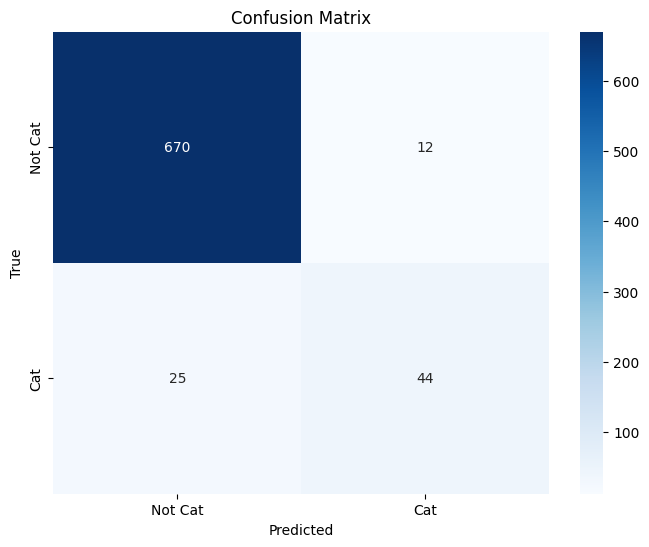

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_classes are defined from the previous code

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Cat', 'Cat'], yticklabels=['Not Cat', 'Cat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix:
 [[670  12]
 [ 25  44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       682
           1       0.79      0.64      0.70        69

    accuracy                           0.95       751
   macro avg       0.87      0.81      0.84       751
weighted avg       0.95      0.95      0.95       751



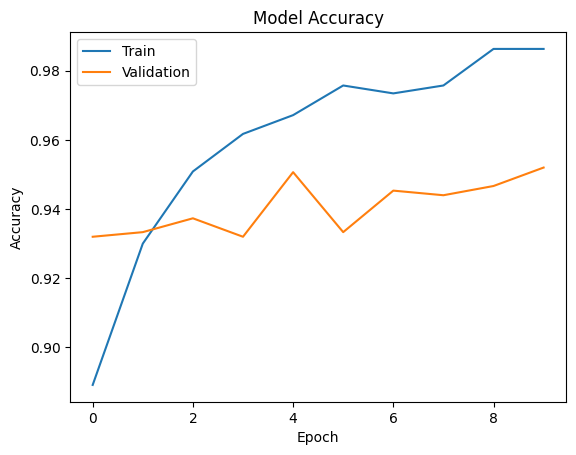

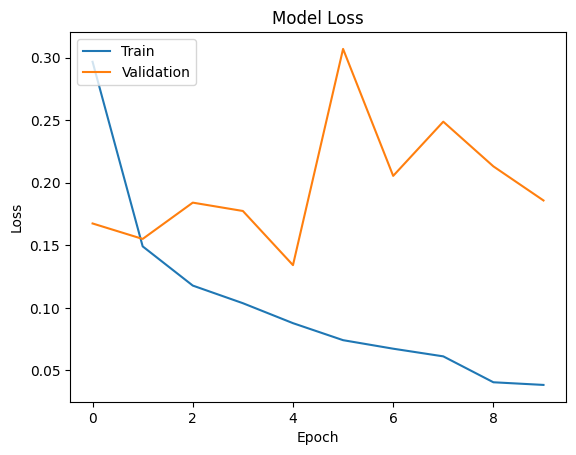

In [9]:
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test, y_pred_classes)  # Use y_pred_classes instead of predicted_classes
print("Confusion Matrix:\n", cm)

cr = classification_report(y_test, y_pred_classes)  # Use y_pred_classes instead of predicted_classes
print("Classification Report:\n", cr)

# Step 12: Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
model.save('/content/model.h5')

model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
Predicted class index for /content/download (1).jpeg: 1
Predicted class name for /content/download (1).jpeg: cat


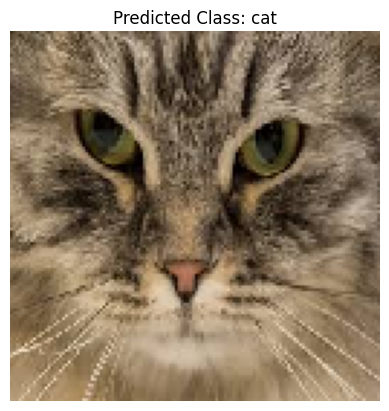

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class index for /content/download (2).jpeg: 0
Predicted class name for /content/download (2).jpeg: not cat


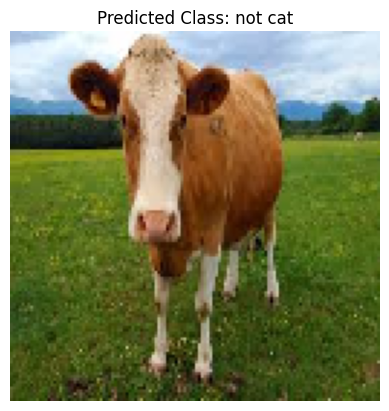

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class index for /content/download (3).jpeg: 0
Predicted class name for /content/download (3).jpeg: not cat


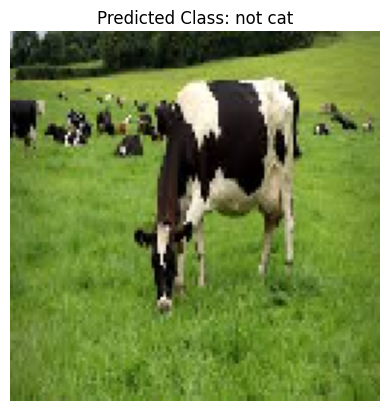

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class index for /content/download (4).jpeg: 0
Predicted class name for /content/download (4).jpeg: not cat


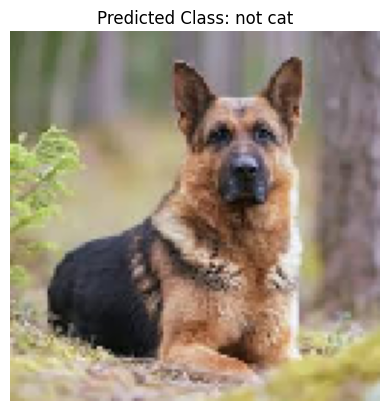

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class index for /content/download (5).jpeg: 0
Predicted class name for /content/download (5).jpeg: not cat


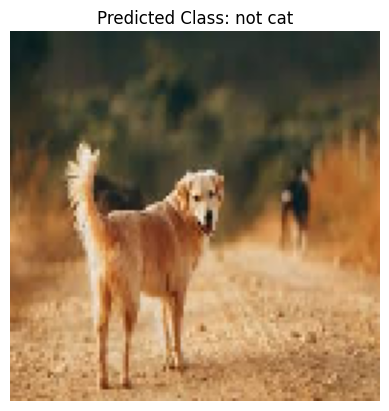

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class index for /content/images (1).jpeg: 0
Predicted class name for /content/images (1).jpeg: not cat


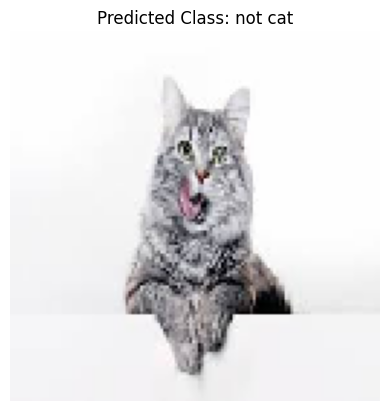

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class index for /content/image.jpeg: 0
Predicted class name for /content/image.jpeg: not cat


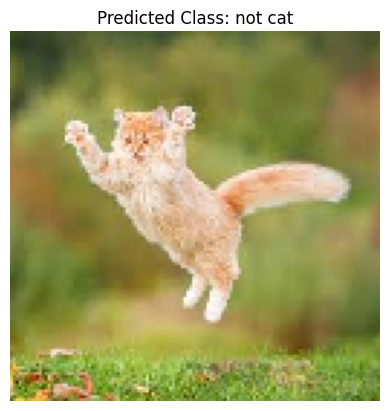

In [14]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load the saved ResNet152V2 model
model = load_model('/content/model.h5')  # Update with your model path
print("model loaded successfully!")

# List of test image paths (update with your image paths)
test_image_paths = [
    '/content/download (1).jpeg',
    '/content/download (2).jpeg',
    '/content/download (3).jpeg',
    '/content/download (4).jpeg',
    '/content/download (5).jpeg',
    '/content/images (1).jpeg',
    '/content/image.jpeg'

]

# Define class labels (update with your actual labels)
class_labels = ['not cat', 'cat']

# Function to process and predict each image
for image_path in test_image_paths:
    # Load and preprocess the image
    img = load_img(image_path, target_size=(128, 128))  # Resize to 224x224
    img_array = img_to_array(img)  # Convert to array
    img_array = preprocess_input(img_array)  # Apply ResNet152V2 preprocessing
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the label of the test image
    predictions = model.predict(img_array)

    # Get the index of the predicted class
    predicted_class = np.argmax(predictions)
    print(f"Predicted class index for {image_path}: {predicted_class}")

    # Map the predicted index to the class name
    predicted_class_name = class_labels[predicted_class]
    print(f"Predicted class name for {image_path}: {predicted_class_name}")

    # Display the test image with the predicted label
    plt.figure()
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class_name}")
    plt.axis('off')
    plt.show()